## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

"""
建立實驗組合
"""
optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]
reduce_lr_factor = [0.99, 0.5, 0.1]
redice_lr_patient = [3,5,10]

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
import itertools

"""
以迴圈方式遍歷組合來訓練模型
"""
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.99, reduce_patient: 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizatio

50000/50000 [==============================] - 1s 18us/step - loss: 1.3210 - acc: 0.5391 - val_loss: 1.5077 - val_acc: 0.4674
Epoch 12/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.2978 - acc: 0.5477 - val_loss: 1.5085 - val_acc: 0.4625
Epoch 13/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.2732 - acc: 0.5562 - val_loss: 1.4855 - val_acc: 0.4777
Epoch 14/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.2510 - acc: 0.5666 - val_loss: 1.4874 - val_acc: 0.4722
Epoch 15/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.2290 - acc: 0.5744 - val_loss: 1.4721 - val_acc: 0.4818
Epoch 16/25
50000/50000 [==============================] - 1s 16us/step - loss: 1.2104 - acc: 0.5828 - val_loss: 1.4633 - val_acc: 0.4840
Epoch 17/25
50000/50000 [==============================] - 1s 16us/step - loss: 1.1894 - acc: 0.5889 - val_loss: 1.4603 - val_acc: 0.4843
Epoch 18/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 2s 34us/step - loss: 2.2374 - acc: 0.2665 - val_loss: 2.1134 - val_acc: 0.3199
Epoch 2/25
50000/50000 [==============================] - 1s 16us/step - loss: 1.7464 - acc: 0.3915 - val_loss: 1.8309 - val_acc: 0.3712
Epoch 3/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.6215 - acc: 0.4336 - val_loss: 1.6832 - val_acc: 0.4151
Epoch 4/25
50000/50000 [==============================] - 1s 16us/step - loss: 1.5498 - acc: 0.4570 - val_loss: 1.6402 - val_acc: 0.4292
Epoch 5/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.4975 - acc: 0.4769 - val_loss: 1.5867 - val_acc: 0.4401
Epoch 6/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.4530 - acc: 0.4918 - val_loss: 1.5679 - val_acc: 0.4515
Epoch 7/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.4174 - acc: 0.5033 - val_loss: 1.5476 - val_acc

50000/50000 [==============================] - 1s 17us/step - loss: 1.2428 - acc: 0.5699 - val_loss: 1.4937 - val_acc: 0.4710
Epoch 24/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.2302 - acc: 0.5749 - val_loss: 1.4881 - val_acc: 0.4726
Epoch 25/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.2190 - acc: 0.5781 - val_loss: 1.4843 - val_acc: 0.4756
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_laye

Epoch 11/25
50000/50000 [==============================] - 1s 16us/step - loss: 1.4259 - acc: 0.5038 - val_loss: 1.5523 - val_acc: 0.4559
Epoch 12/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.4078 - acc: 0.5120 - val_loss: 1.5463 - val_acc: 0.4569
Epoch 13/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.3896 - acc: 0.5168 - val_loss: 1.5324 - val_acc: 0.4626
Epoch 14/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.3699 - acc: 0.5233 - val_loss: 1.5231 - val_acc: 0.4677
Epoch 15/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.3528 - acc: 0.5309 - val_loss: 1.5133 - val_acc: 0.4693
Epoch 16/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.3371 - acc: 0.5353 - val_loss: 1.5102 - val_acc: 0.4692
Epoch 17/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.3226 - acc: 0.5399 - val_loss: 1.5065 - val_acc: 0.4708
Epoch 18/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 2s 46us/step - loss: 2.3797 - acc: 0.2338 - val_loss: 2.2434 - val_acc: 0.2838
Epoch 2/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.8993 - acc: 0.3493 - val_loss: 1.9331 - val_acc: 0.3477
Epoch 3/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.7521 - acc: 0.3914 - val_loss: 1.7930 - val_acc: 0.3864
Epoch 4/25
50000/50000 [==============================] - 1s 16us/step - loss: 1.6711 - acc: 0.4177 - val_loss: 1.7401 - val_acc: 0.4000
Epoch 5/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.6171 - acc: 0.4355 - val_loss: 1.6912 - val_acc: 0.4120
Epoch 6/25
50000/50000 [==============================] - 1s 16us/step - loss: 1.5731 - acc: 0.4500 - val_loss: 1.6706 - val_acc: 0.4112
Epoch 7/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.5375 - acc: 0.4626 - val_loss: 1.6442 - val_acc

Epoch 22/25
50000/50000 [==============================] - 1s 18us/step - loss: 0.4981 - acc: 0.8311 - val_loss: 1.9907 - val_acc: 0.4525

Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.0009509901772253215.
Epoch 23/25
50000/50000 [==============================] - 1s 18us/step - loss: 0.4525 - acc: 0.8492 - val_loss: 2.2627 - val_acc: 0.4172
Epoch 24/25
50000/50000 [==============================] - 1s 17us/step - loss: 0.4291 - acc: 0.8578 - val_loss: 2.1129 - val_acc: 0.4444
Epoch 25/25
50000/50000 [==============================] - 1s 17us/step - loss: 0.4009 - acc: 0.8662 - val_loss: 2.0094 - val_acc: 0.4853

Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.0009414802846731617.
Numbers of exp: 10, reduce_factor: 0.99, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_____________________________

Epoch 7/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.2198 - acc: 0.5661 - val_loss: 1.4804 - val_acc: 0.4732
Epoch 8/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.1751 - acc: 0.5846 - val_loss: 1.6172 - val_acc: 0.4326
Epoch 9/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.1321 - acc: 0.6000 - val_loss: 1.5171 - val_acc: 0.4729
Epoch 10/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.0985 - acc: 0.6111 - val_loss: 1.4429 - val_acc: 0.4889
Epoch 11/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.0545 - acc: 0.6267 - val_loss: 1.5875 - val_acc: 0.4419
Epoch 12/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.0185 - acc: 0.6390 - val_loss: 1.4722 - val_acc: 0.4787
Epoch 13/25
50000/50000 [==============================] - 1s 18us/step - loss: 0.9812 - acc: 0.6524 - val_loss: 1.4691 - val_acc: 0.4914
Epoch 14/25
50000/50000 [============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 63us/step - loss: 1.8722 - acc: 0.3580 - val_loss: 1.9101 - val_acc: 0.3565
Epoch 2/25
50000/50000 [==============================] - 1s 20us/step - loss: 1.5443 - acc: 0.4582 - val_loss: 1.6463 - val_acc: 0.4199
Epoch 3/25
50000/50000 [==============================] - 1s 19us/step - loss: 1.4475 - acc: 0.4933 - val_loss: 1.6477 - val_acc: 0.4194
Epoch 4/25
50000/50000 [==============================] - 1s 19us/step - loss: 1.3838 - acc: 0.5151 - val_loss: 1.6102 - val_acc: 0.4303
Epoch 5/25
50000/50000 [==============================] - 1s 19us/step - loss: 1.3334 - acc: 0.5330 - val_loss: 1.5284 - val_acc: 0.4634
Epoch 6/25
50000/50000 [==============================] - 1s 19us/step - loss: 1.2899 - acc: 0.5504 - val_loss: 1.5064 - val_acc: 0.4691
Epoch 7/25
50000/50000 [==============================] - 1s 19us/step - loss: 1.2557 - acc: 0.5638 - val_loss: 1.5209 - val_acc

50000/50000 [==============================] - 1s 19us/step - loss: 0.9072 - acc: 0.6976 - val_loss: 1.4351 - val_acc: 0.5058
Epoch 25/25
50000/50000 [==============================] - 1s 19us/step - loss: 0.8936 - acc: 0.7032 - val_loss: 1.4393 - val_acc: 0.5080
Numbers of exp: 15, reduce_factor: 0.10, reduce_patient: 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_46 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizati

50000/50000 [==============================] - 1s 18us/step - loss: 1.6394 - acc: 0.4286 - val_loss: 1.7278 - val_acc: 0.3997
Epoch 12/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.6254 - acc: 0.4321 - val_loss: 1.7201 - val_acc: 0.4018
Epoch 13/25
50000/50000 [==============================] - 1s 19us/step - loss: 1.6121 - acc: 0.4363 - val_loss: 1.7083 - val_acc: 0.4065
Epoch 14/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.5989 - acc: 0.4429 - val_loss: 1.7002 - val_acc: 0.4085
Epoch 15/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.5878 - acc: 0.4452 - val_loss: 1.6900 - val_acc: 0.4111
Epoch 16/25
50000/50000 [==============================] - 1s 20us/step - loss: 1.5777 - acc: 0.4493 - val_loss: 1.6850 - val_acc: 0.4142
Epoch 17/25
50000/50000 [==============================] - 1s 20us/step - loss: 1.5675 - acc: 0.4530 - val_loss: 1.6793 - val_acc: 0.4136
Epoch 18/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 85us/step - loss: 1.8489 - acc: 0.3650 - val_loss: 2.0482 - val_acc: 0.3339
Epoch 2/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.5481 - acc: 0.4483 - val_loss: 2.4759 - val_acc: 0.2598
Epoch 3/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.4287 - acc: 0.4951 - val_loss: 2.4910 - val_acc: 0.2596
Epoch 4/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.3571 - acc: 0.5197 - val_loss: 2.5283 - val_acc: 0.2725

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0009900000470224768.
Epoch 5/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.2797 - acc: 0.5479 - val_loss: 1.9947 - val_acc: 0.3327
Epoch 6/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.2247 - acc: 0.5680 - val_loss: 2.0696 - val_acc: 0.3621
Epoch 7/25
50000/50000 [=======================


Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.0009320654743351042.
Epoch 21/25
50000/50000 [==============================] - 1s 23us/step - loss: 0.6751 - acc: 0.7657 - val_loss: 2.1188 - val_acc: 0.4017
Epoch 22/25
50000/50000 [==============================] - 1s 20us/step - loss: 0.6441 - acc: 0.7794 - val_loss: 2.0373 - val_acc: 0.4289
Epoch 23/25
50000/50000 [==============================] - 1s 20us/step - loss: 0.6179 - acc: 0.7870 - val_loss: 1.9869 - val_acc: 0.4435
Epoch 24/25
50000/50000 [==============================] - 1s 19us/step - loss: 0.5936 - acc: 0.7974 - val_loss: 2.0888 - val_acc: 0.4112
Epoch 25/25
50000/50000 [==============================] - 1s 22us/step - loss: 0.5638 - acc: 0.8058 - val_loss: 2.0847 - val_acc: 0.4514

Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.0009227448242017999.
Numbers of exp: 20, reduce_factor: 0.99, reduce_patient: 10
_________________________________________________________________
Layer (type)          

50000/50000 [==============================] - 1s 18us/step - loss: 1.1709 - acc: 0.5863 - val_loss: 1.8538 - val_acc: 0.3520

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0004613724013324827.
Epoch 8/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.0419 - acc: 0.6386 - val_loss: 1.4360 - val_acc: 0.4916
Epoch 9/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.0001 - acc: 0.6540 - val_loss: 1.4473 - val_acc: 0.4949
Epoch 10/25
50000/50000 [==============================] - 1s 18us/step - loss: 0.9671 - acc: 0.6665 - val_loss: 1.4710 - val_acc: 0.4890
Epoch 11/25
50000/50000 [==============================] - 1s 18us/step - loss: 0.9310 - acc: 0.6791 - val_loss: 1.5496 - val_acc: 0.4755

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.00023068620066624135.
Epoch 12/25
50000/50000 [==============================] - 1s 19us/step - loss: 0.8582 - acc: 0.7088 - val_loss: 1.3628 - val_acc: 0.5206
Epoch 13/25
50000/50000

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 93us/step - loss: 2.2969 - acc: 0.2403 - val_loss: 2.1883 - val_acc: 0.2815
Epoch 2/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.9394 - acc: 0.3334 - val_loss: 2.0342 - val_acc: 0.3250
Epoch 3/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.8004 - acc: 0.3735 - val_loss: 1.8912 - val_acc: 0.3577
Epoch 4/25
50000/50000 [==============================] - 1s 19us/step - loss: 1.7139 - acc: 0.4033 - val_loss: 1.8060 - val_acc: 0.3814
Epoch 5/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.6510 - acc: 0.4220 - val_loss: 1.7669 - val_acc: 0.3943
Epoch 6/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.6017 - acc: 0.4408 - val_loss: 1.7073 - val_acc: 0.4092
Epoch 7/25
50000/50000 [==============================] - 1s 19us/step - loss: 1.5614 - acc: 0.4560 - val_loss: 1.6684 - val_acc

50000/50000 [==============================] - 1s 18us/step - loss: 1.2325 - acc: 0.5769 - val_loss: 1.5039 - val_acc: 0.4731
Epoch 25/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.2207 - acc: 0.5804 - val_loss: 1.5113 - val_acc: 0.4728
Numbers of exp: 25, reduce_factor: 0.10, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_76 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizati

Epoch 12/25
50000/50000 [==============================] - 1s 19us/step - loss: 1.4309 - acc: 0.4998 - val_loss: 1.5930 - val_acc: 0.4459
Epoch 13/25
50000/50000 [==============================] - 1s 19us/step - loss: 1.4096 - acc: 0.5077 - val_loss: 1.5769 - val_acc: 0.4471
Epoch 14/25
50000/50000 [==============================] - 1s 20us/step - loss: 1.3898 - acc: 0.5155 - val_loss: 1.5732 - val_acc: 0.4486
Epoch 15/25
50000/50000 [==============================] - 1s 20us/step - loss: 1.3703 - acc: 0.5228 - val_loss: 1.5639 - val_acc: 0.4532
Epoch 16/25
50000/50000 [==============================] - 1s 22us/step - loss: 1.3532 - acc: 0.5312 - val_loss: 1.5600 - val_acc: 0.4582
Epoch 17/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.3361 - acc: 0.5371 - val_loss: 1.5542 - val_acc: 0.4555
Epoch 18/25
50000/50000 [==============================] - 1s 19us/step - loss: 1.3204 - acc: 0.5423 - val_loss: 1.5434 - val_acc: 0.4597
Epoch 19/25
50000/50000 [=========

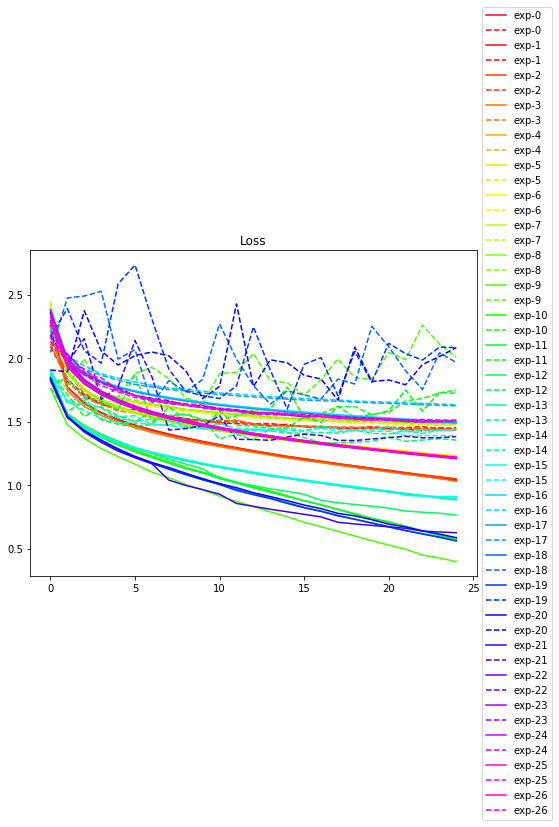

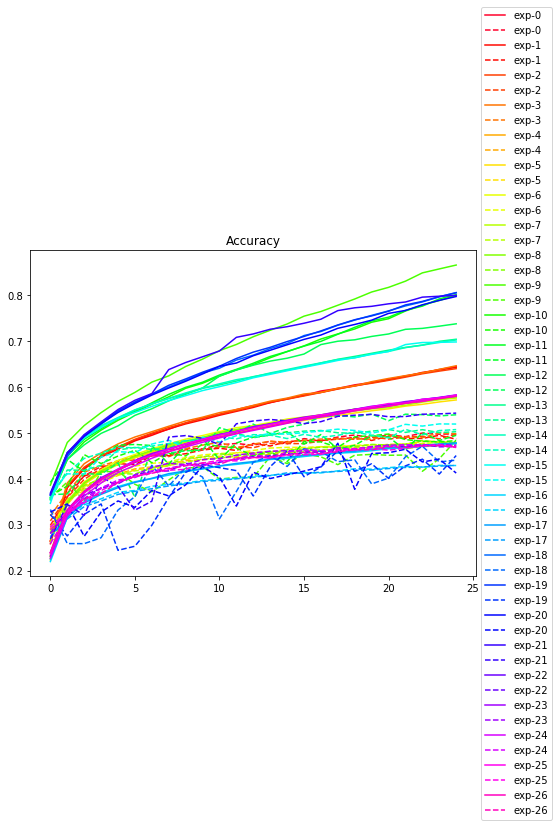

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()